In [8]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Denoising Diffusion Probabilistic Model on 3D data

This tutorial illustrates how to use MONAI for training a denoising diffusion probabilistic model (DDPM)[1] to create synthetic 3D images.

[1] - [Ho et al. "Denoising Diffusion Probabilistic Models"](https://arxiv.org/abs/2006.11239)


## Setup environment

In [9]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [10]:
import os
import tempfile
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import SimpleITK as sitk
import random

import glob
from sklearn.model_selection import train_test_split
from monai.transforms import (
    LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd, ScaleIntensityRanged,
    MaskIntensityd, CropForegroundd, Compose, ToTensord, CenterSpatialCropd, Transform
)

from monai.config import print_config
from monai.data import Dataset, PersistentDataset, DataLoader

from monai.utils import set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler, DDIMScheduler
print_config()

MONAI version: 1.5.0
Numpy version: 2.2.6
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: d388d1c6fec8cb3a0eebee5b5a0b9776ca59ca83
MONAI __file__: /users/<username>/.conda/envs/ddpm_env/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.2
ITK version: 5.4.4
Nibabel version: 5.3.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.15.3
Pillow version: 11.2.1
Tensorboard version: 2.19.0
gdown version: 5.2.0
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 7.0.0
pandas version: 2.2.3
einops version: 0.8.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    h

## Setup data directory

You can specify a directory with the MONAI_DATA_DIRECTORY environment variable.

This allows you to save results and reuse downloads.

If not specified a temporary directory will be used.

In [11]:
root_dir = "DATASET"
assert os.path.isdir(root_dir), "Check PI-CAI path"
print(root_dir)


DATASET


## Set deterministic training for reproducibility

In [12]:
set_determinism(42)

## Setup Decathlon Dataset and training and validation data loaders

In this tutorial, we will use the 3D T1 weighted brain images from the [2016 and 2017 Brain Tumor Segmentation (BraTS) challenges](https://www.med.upenn.edu/sbia/brats2017/data.html). This dataset can be easily downloaded using the [DecathlonDataset](https://docs.monai.io/en/stable/apps.html#monai.apps.DecathlonDataset) from MONAI (`task="Task01_BrainTumour"`). To load the training and validation images, we are using the `data_transform` transformations that are responsible for the following:

1. `LoadImaged`:  Loads the brain images from files.
2. `Lambdad`: Choose channel 1 of the image, which is the T1-weighted image.
3. `EnsureChannelFirstd`: Add the channel dimension of the input data.
4. `ScaleIntensityd`: Apply a min-max scaling in the intensity values of each image to be in the `[0, 1]` range.
5. `CenterSpatialCropd`: Crop the background of the images using a roi of size `[160, 200, 155]`.
6. `Resized`: Resize the images to a volume with size `[32, 40, 32]`.

For the data loader, we are using mini-batches of 8 images, which consumes about 21GB of GPU memory during training. Please, reduce this value to run on smaller GPUs.

In [13]:
# data_transform = Compose(
#     [
#         LoadImaged(keys=["image"]),
#         Lambdad(keys="image", func=lambda x: x[:, :, :, 1]),
#         EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
#         ScaleIntensityd(keys=["image"]),
#         CenterSpatialCropd(keys=["image"], roi_size=[160, 200, 155]),
#         Resized(keys=["image"], spatial_size=(32, 40, 32)),
#     ]
# )

image_paths = sorted(glob.glob(f"{root_dir}/*/*_t2w.mha"))
print(f"Found {len(image_paths)} volumes.")

Found 3 volumes.


In [26]:
# ┌──────────────────────────────────────────────────────────────────────────┐
# │ CELL 1: Data prep & patch loader                                        │
# └──────────────────────────────────────────────────────────────────────────┘

import os, glob
import SimpleITK as sitk
import torch
from monai.transforms import (
    Transform,
    Orientationd,
    Spacingd,
    ScaleIntensityRanged,
    CropForegroundd,
    RandSpatialCropd,
    DivisiblePadd,
    ToTensord,
    Compose,
)
from monai.data import PersistentDataset, DataLoader
from sklearn.model_selection import train_test_split

# 1) Custom MHA loader
class LoadMHAwithSimpleITK(Transform):
    def __init__(self, image_key="image"):
        self.image_key = image_key
        self.reader = sitk.ImageFileReader()
        self.reader.SetImageIO("MetaImageIO")
    def __call__(self, data):
        path = data[self.image_key]
        self.reader.SetFileName(path)
        sitk_img = self.reader.Execute()
        arr = sitk.GetArrayFromImage(sitk_img)    # (Z,Y,X)
        data[self.image_key] = torch.from_numpy(arr[None].astype("float32"))
        return data

# 2) File list
root_dir    = "DATASET"  # adjust if needed
image_paths = sorted(glob.glob(f"{root_dir}/*/*_t2w.mha"))
data_dicts  = [{"image": p} for p in image_paths]
train_paths, val_paths = train_test_split(
    image_paths, test_size=0.3, random_state=42
)

train_dicts = [{"image": p} for p in train_paths]
val_dicts   = [{"image": p} for p in val_paths]

# 3) Patch+ROI pipeline
z_res      = 1.0
pixdim     = (0.5, 0.5, z_res)
margin     = (8, 32, 32)       # voxels around prostate ROI
patch_size = (64, 128, 128)    # final patch size

transforms = Compose([
    LoadMHAwithSimpleITK(),
    Orientationd(keys=["image"], axcodes="RAS"),
    Spacingd(keys=["image"], pixdim=pixdim, mode="linear"),
    ScaleIntensityRanged(
        keys=["image"], a_min=-100, a_max=400,
        b_min=0.0,  b_max=1.0,  clip=True
    ),
    CropForegroundd(keys=["image"], source_key="image", margin=margin),
    RandSpatialCropd(keys=["image"], roi_size=patch_size, random_size=False),
    DivisiblePadd(keys=["image"], k=8, mode="constant", constant_values=0),
    ToTensord(keys=["image"]),
])

# 4) Dataset & DataLoader
cache_dir = "./monai_cache"
os.makedirs(cache_dir, exist_ok=True)
train_ds     = PersistentDataset(data=train_dicts,
                                 transform=transforms,
                                 cache_dir=os.path.join(cache_dir, "train"))
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True,
                          num_workers=4, pin_memory=True,
                          persistent_workers=True)

# +++ NEW: validation set (no shuffle) +++
val_ds     = PersistentDataset(data=val_dicts,
                               transform=transforms,
                               cache_dir=os.path.join(cache_dir, "val"))
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False,
                        num_workers=4, pin_memory=True,
                        persistent_workers=True)


dict_keys(['linear_beta', 'scaled_linear_beta', 'sigmoid_beta', 'cosine'])


VAE ep0: 100%|██████████████| 2/2 [00:00<00:00, 18.46it/s, loss=0.316]


→ VAE epoch 0 avg loss: 0.1580


VAE ep1: 100%|██████████████| 2/2 [00:00<00:00, 33.56it/s, loss=0.306]


→ VAE epoch 1 avg loss: 0.1532


VAE ep2: 100%|██████████████| 2/2 [00:00<00:00, 37.19it/s, loss=0.297]


→ VAE epoch 2 avg loss: 0.1484


VAE ep3: 100%|██████████████| 2/2 [00:00<00:00, 44.69it/s, loss=0.263]


→ VAE epoch 3 avg loss: 0.1314


VAE ep4: 100%|██████████████| 2/2 [00:00<00:00, 36.80it/s, loss=0.228]


→ VAE epoch 4 avg loss: 0.1140


DDPM ep0: 100%|██████████████| 2/2 [00:00<00:00, 16.42it/s, loss=1.99]


→ DDPM epoch 0 avg loss: 0.9967


DDPM ep1: 100%|██████████████| 2/2 [00:00<00:00, 19.36it/s, loss=1.99]


→ DDPM epoch 1 avg loss: 0.9969


DDPM ep2: 100%|██████████████| 2/2 [00:00<00:00, 17.31it/s, loss=1.99]


→ DDPM epoch 2 avg loss: 0.9957


DDPM ep3: 100%|██████████████| 2/2 [00:00<00:00, 17.39it/s, loss=1.96]


→ DDPM epoch 3 avg loss: 0.9798


DDPM ep4: 100%|██████████████| 2/2 [00:00<00:00, 18.09it/s, loss=1.98]


→ DDPM epoch 4 avg loss: 0.9899


DDPM ep5: 100%|██████████████| 2/2 [00:00<00:00, 17.27it/s, loss=1.94]


→ DDPM epoch 5 avg loss: 0.9708


DDPM ep6: 100%|██████████████| 2/2 [00:00<00:00, 18.90it/s, loss=1.92]


→ DDPM epoch 6 avg loss: 0.9601


DDPM ep7: 100%|██████████████| 2/2 [00:00<00:00, 17.28it/s, loss=1.92]


→ DDPM epoch 7 avg loss: 0.9586


DDPM ep8: 100%|███████████████| 2/2 [00:00<00:00, 18.24it/s, loss=1.9]


→ DDPM epoch 8 avg loss: 0.9500


DDPM ep9: 100%|██████████████| 2/2 [00:00<00:00, 18.29it/s, loss=1.89]


→ DDPM epoch 9 avg loss: 0.9428


DDPM ep10: 100%|█████████████| 2/2 [00:00<00:00, 18.55it/s, loss=1.88]


→ DDPM epoch 10 avg loss: 0.9402


DDPM ep11: 100%|█████████████| 2/2 [00:00<00:00, 16.71it/s, loss=1.88]


→ DDPM epoch 11 avg loss: 0.9414


DDPM ep12: 100%|█████████████| 2/2 [00:00<00:00, 19.00it/s, loss=1.86]


→ DDPM epoch 12 avg loss: 0.9290


DDPM ep13: 100%|█████████████| 2/2 [00:00<00:00, 16.13it/s, loss=1.85]


→ DDPM epoch 13 avg loss: 0.9246


DDPM ep14: 100%|█████████████| 2/2 [00:00<00:00, 16.33it/s, loss=1.86]


→ DDPM epoch 14 avg loss: 0.9279


DDPM ep15: 100%|█████████████| 2/2 [00:00<00:00, 17.23it/s, loss=1.84]


→ DDPM epoch 15 avg loss: 0.9195


DDPM ep16: 100%|█████████████| 2/2 [00:00<00:00, 16.33it/s, loss=1.83]


→ DDPM epoch 16 avg loss: 0.9137


DDPM ep17: 100%|█████████████| 2/2 [00:00<00:00, 18.10it/s, loss=1.82]


→ DDPM epoch 17 avg loss: 0.9103


DDPM ep18: 100%|█████████████| 2/2 [00:00<00:00, 17.87it/s, loss=1.81]


→ DDPM epoch 18 avg loss: 0.9044


DDPM ep19: 100%|█████████████| 2/2 [00:00<00:00, 17.93it/s, loss=1.83]


→ DDPM epoch 19 avg loss: 0.9138


DDPM ep20: 100%|█████████████| 2/2 [00:00<00:00, 16.44it/s, loss=1.77]


→ DDPM epoch 20 avg loss: 0.8839


DDPM ep21: 100%|█████████████| 2/2 [00:00<00:00, 18.31it/s, loss=1.77]


→ DDPM epoch 21 avg loss: 0.8851


DDPM ep22: 100%|█████████████| 2/2 [00:00<00:00, 16.78it/s, loss=1.76]


→ DDPM epoch 22 avg loss: 0.8816


DDPM ep23: 100%|█████████████| 2/2 [00:00<00:00, 18.81it/s, loss=1.74]


→ DDPM epoch 23 avg loss: 0.8717


DDPM ep24: 100%|█████████████| 2/2 [00:00<00:00, 17.59it/s, loss=1.74]


→ DDPM epoch 24 avg loss: 0.8725


DDPM ep25: 100%|█████████████| 2/2 [00:00<00:00, 16.51it/s, loss=1.72]


→ DDPM epoch 25 avg loss: 0.8585


DDPM ep26: 100%|█████████████| 2/2 [00:00<00:00, 16.91it/s, loss=1.72]


→ DDPM epoch 26 avg loss: 0.8583


DDPM ep27: 100%|█████████████| 2/2 [00:00<00:00, 18.60it/s, loss=1.81]


→ DDPM epoch 27 avg loss: 0.9044


DDPM ep28: 100%|█████████████| 2/2 [00:00<00:00, 18.32it/s, loss=1.85]


→ DDPM epoch 28 avg loss: 0.9267


DDPM ep29: 100%|█████████████| 2/2 [00:00<00:00, 16.57it/s, loss=1.71]


→ DDPM epoch 29 avg loss: 0.8560


DDPM ep30: 100%|█████████████| 2/2 [00:00<00:00, 17.94it/s, loss=1.69]


→ DDPM epoch 30 avg loss: 0.8433


DDPM ep31: 100%|█████████████| 2/2 [00:00<00:00, 18.35it/s, loss=1.68]


→ DDPM epoch 31 avg loss: 0.8412


DDPM ep32: 100%|█████████████| 2/2 [00:00<00:00, 17.96it/s, loss=1.72]


→ DDPM epoch 32 avg loss: 0.8587


DDPM ep33: 100%|█████████████| 2/2 [00:00<00:00, 18.21it/s, loss=1.66]


→ DDPM epoch 33 avg loss: 0.8315


DDPM ep34: 100%|██████████████| 2/2 [00:00<00:00, 15.99it/s, loss=1.7]


→ DDPM epoch 34 avg loss: 0.8478


DDPM ep35: 100%|█████████████| 2/2 [00:00<00:00, 17.37it/s, loss=1.65]


→ DDPM epoch 35 avg loss: 0.8249


DDPM ep36: 100%|██████████████| 2/2 [00:00<00:00, 18.98it/s, loss=1.8]


→ DDPM epoch 36 avg loss: 0.9007


DDPM ep37: 100%|█████████████| 2/2 [00:00<00:00, 18.08it/s, loss=1.62]


→ DDPM epoch 37 avg loss: 0.8092


DDPM ep38: 100%|█████████████| 2/2 [00:00<00:00, 17.70it/s, loss=1.68]


→ DDPM epoch 38 avg loss: 0.8412


DDPM ep39: 100%|█████████████| 2/2 [00:00<00:00, 18.66it/s, loss=1.65]


→ DDPM epoch 39 avg loss: 0.8243


DDPM ep40: 100%|█████████████| 2/2 [00:00<00:00, 15.90it/s, loss=1.61]


→ DDPM epoch 40 avg loss: 0.8067


DDPM ep41: 100%|█████████████| 2/2 [00:00<00:00, 16.39it/s, loss=1.61]


→ DDPM epoch 41 avg loss: 0.8064


DDPM ep42: 100%|█████████████| 2/2 [00:00<00:00, 11.88it/s, loss=1.64]


→ DDPM epoch 42 avg loss: 0.8210


DDPM ep43: 100%|█████████████| 2/2 [00:00<00:00, 18.11it/s, loss=1.59]


→ DDPM epoch 43 avg loss: 0.7947


DDPM ep44: 100%|█████████████| 2/2 [00:00<00:00, 19.44it/s, loss=1.61]


→ DDPM epoch 44 avg loss: 0.8034


DDPM ep45: 100%|█████████████| 2/2 [00:00<00:00, 17.60it/s, loss=1.82]


→ DDPM epoch 45 avg loss: 0.9085


DDPM ep46: 100%|█████████████| 2/2 [00:00<00:00, 20.17it/s, loss=1.57]


→ DDPM epoch 46 avg loss: 0.7861


DDPM ep47: 100%|█████████████| 2/2 [00:00<00:00, 17.44it/s, loss=1.73]


→ DDPM epoch 47 avg loss: 0.8654


DDPM ep48: 100%|█████████████| 2/2 [00:00<00:00, 19.47it/s, loss=1.62]


→ DDPM epoch 48 avg loss: 0.8091


DDPM ep49: 100%|█████████████| 2/2 [00:00<00:00, 17.26it/s, loss=1.56]


→ DDPM epoch 49 avg loss: 0.7808


DDPM ep50: 100%|█████████████| 2/2 [00:00<00:00, 17.25it/s, loss=1.57]


→ DDPM epoch 50 avg loss: 0.7850


DDPM ep51: 100%|█████████████| 2/2 [00:00<00:00, 15.09it/s, loss=1.58]


→ DDPM epoch 51 avg loss: 0.7911


DDPM ep52: 100%|█████████████| 2/2 [00:00<00:00, 16.88it/s, loss=1.57]


→ DDPM epoch 52 avg loss: 0.7832


DDPM ep53: 100%|█████████████| 2/2 [00:00<00:00, 16.64it/s, loss=1.57]


→ DDPM epoch 53 avg loss: 0.7851


DDPM ep54: 100%|█████████████| 2/2 [00:00<00:00, 13.91it/s, loss=1.58]


→ DDPM epoch 54 avg loss: 0.7904


DDPM ep55: 100%|█████████████| 2/2 [00:00<00:00, 17.00it/s, loss=1.53]


→ DDPM epoch 55 avg loss: 0.7627


DDPM ep56: 100%|█████████████| 2/2 [00:00<00:00, 15.81it/s, loss=1.51]


→ DDPM epoch 56 avg loss: 0.7532


DDPM ep57: 100%|█████████████| 2/2 [00:00<00:00, 16.77it/s, loss=1.81]


→ DDPM epoch 57 avg loss: 0.9040


DDPM ep58: 100%|█████████████| 2/2 [00:00<00:00, 16.25it/s, loss=1.59]


→ DDPM epoch 58 avg loss: 0.7950


DDPM ep59: 100%|█████████████| 2/2 [00:00<00:00, 15.07it/s, loss=1.51]


→ DDPM epoch 59 avg loss: 0.7559


DDPM ep60: 100%|█████████████| 2/2 [00:00<00:00, 16.99it/s, loss=1.49]


→ DDPM epoch 60 avg loss: 0.7465


DDPM ep61: 100%|██████████████| 2/2 [00:00<00:00, 16.20it/s, loss=1.5]


→ DDPM epoch 61 avg loss: 0.7484


DDPM ep62: 100%|█████████████| 2/2 [00:00<00:00, 18.24it/s, loss=1.49]


→ DDPM epoch 62 avg loss: 0.7474


DDPM ep63: 100%|█████████████| 2/2 [00:00<00:00, 16.06it/s, loss=1.56]


→ DDPM epoch 63 avg loss: 0.7793


DDPM ep64: 100%|██████████████| 2/2 [00:00<00:00, 18.09it/s, loss=1.5]


→ DDPM epoch 64 avg loss: 0.7492


DDPM ep65: 100%|█████████████| 2/2 [00:00<00:00, 18.54it/s, loss=1.48]


→ DDPM epoch 65 avg loss: 0.7416


DDPM ep66: 100%|█████████████| 2/2 [00:00<00:00, 16.86it/s, loss=1.46]


→ DDPM epoch 66 avg loss: 0.7320


DDPM ep67: 100%|█████████████| 2/2 [00:00<00:00, 15.49it/s, loss=1.52]


→ DDPM epoch 67 avg loss: 0.7605


DDPM ep68: 100%|█████████████| 2/2 [00:00<00:00, 15.63it/s, loss=1.77]


→ DDPM epoch 68 avg loss: 0.8844


DDPM ep69: 100%|█████████████| 2/2 [00:00<00:00, 17.88it/s, loss=1.55]


→ DDPM epoch 69 avg loss: 0.7761


DDPM ep70: 100%|█████████████| 2/2 [00:00<00:00, 16.75it/s, loss=1.77]


→ DDPM epoch 70 avg loss: 0.8826


DDPM ep71: 100%|█████████████| 2/2 [00:00<00:00, 17.87it/s, loss=1.47]


→ DDPM epoch 71 avg loss: 0.7330


DDPM ep72: 100%|█████████████| 2/2 [00:00<00:00, 17.14it/s, loss=1.44]


→ DDPM epoch 72 avg loss: 0.7215


DDPM ep73: 100%|█████████████| 2/2 [00:00<00:00, 17.56it/s, loss=1.45]


→ DDPM epoch 73 avg loss: 0.7254


DDPM ep74: 100%|█████████████| 2/2 [00:00<00:00, 16.14it/s, loss=1.44]


→ DDPM epoch 74 avg loss: 0.7205


DDPM ep75: 100%|█████████████| 2/2 [00:00<00:00, 16.54it/s, loss=1.43]


→ DDPM epoch 75 avg loss: 0.7164


DDPM ep76: 100%|█████████████| 2/2 [00:00<00:00, 17.70it/s, loss=1.46]


→ DDPM epoch 76 avg loss: 0.7300


DDPM ep77: 100%|█████████████| 2/2 [00:00<00:00, 17.05it/s, loss=1.41]


→ DDPM epoch 77 avg loss: 0.7064


DDPM ep78: 100%|█████████████| 2/2 [00:00<00:00, 15.77it/s, loss=1.43]


→ DDPM epoch 78 avg loss: 0.7147


DDPM ep79: 100%|█████████████| 2/2 [00:00<00:00, 17.41it/s, loss=1.41]


→ DDPM epoch 79 avg loss: 0.7033


DDPM ep80: 100%|█████████████| 2/2 [00:00<00:00, 16.74it/s, loss=1.43]


→ DDPM epoch 80 avg loss: 0.7163


DDPM ep81: 100%|█████████████| 2/2 [00:00<00:00, 20.00it/s, loss=1.43]


→ DDPM epoch 81 avg loss: 0.7174


DDPM ep82: 100%|█████████████| 2/2 [00:00<00:00, 17.57it/s, loss=1.47]


→ DDPM epoch 82 avg loss: 0.7368


DDPM ep83: 100%|██████████████| 2/2 [00:00<00:00, 20.28it/s, loss=1.4]


→ DDPM epoch 83 avg loss: 0.7001


DDPM ep84: 100%|█████████████| 2/2 [00:00<00:00, 20.00it/s, loss=1.45]


→ DDPM epoch 84 avg loss: 0.7247


DDPM ep85: 100%|█████████████| 2/2 [00:00<00:00, 19.47it/s, loss=1.44]


→ DDPM epoch 85 avg loss: 0.7196


DDPM ep86: 100%|█████████████| 2/2 [00:00<00:00, 19.63it/s, loss=1.38]


→ DDPM epoch 86 avg loss: 0.6902


DDPM ep87: 100%|█████████████| 2/2 [00:00<00:00, 17.47it/s, loss=1.38]


→ DDPM epoch 87 avg loss: 0.6895


DDPM ep88: 100%|█████████████| 2/2 [00:00<00:00, 18.58it/s, loss=1.37]


→ DDPM epoch 88 avg loss: 0.6847


DDPM ep89: 100%|█████████████| 2/2 [00:00<00:00, 18.90it/s, loss=1.38]


→ DDPM epoch 89 avg loss: 0.6908


DDPM ep90: 100%|█████████████| 2/2 [00:00<00:00, 18.63it/s, loss=1.38]


→ DDPM epoch 90 avg loss: 0.6891


DDPM ep91: 100%|█████████████| 2/2 [00:00<00:00, 17.39it/s, loss=1.35]


→ DDPM epoch 91 avg loss: 0.6770


DDPM ep92: 100%|█████████████| 2/2 [00:00<00:00, 20.21it/s, loss=1.36]


→ DDPM epoch 92 avg loss: 0.6799


DDPM ep93: 100%|██████████████| 2/2 [00:00<00:00, 17.20it/s, loss=1.4]


→ DDPM epoch 93 avg loss: 0.6993


DDPM ep94: 100%|█████████████| 2/2 [00:00<00:00, 17.58it/s, loss=1.37]


→ DDPM epoch 94 avg loss: 0.6849


DDPM ep95: 100%|█████████████| 2/2 [00:00<00:00, 16.44it/s, loss=1.37]


→ DDPM epoch 95 avg loss: 0.6871


DDPM ep96: 100%|█████████████| 2/2 [00:00<00:00, 18.62it/s, loss=1.43]


→ DDPM epoch 96 avg loss: 0.7161


DDPM ep97: 100%|█████████████| 2/2 [00:00<00:00, 16.82it/s, loss=1.44]


→ DDPM epoch 97 avg loss: 0.7177


DDPM ep98: 100%|█████████████| 2/2 [00:00<00:00, 18.15it/s, loss=1.49]


→ DDPM epoch 98 avg loss: 0.7460


DDPM ep99: 100%|█████████████| 2/2 [00:00<00:00, 19.03it/s, loss=1.33]


→ DDPM epoch 99 avg loss: 0.6649


DDPM ep100: 100%|████████████| 2/2 [00:00<00:00, 20.09it/s, loss=1.67]


→ DDPM epoch 100 avg loss: 0.8354


DDPM ep101: 100%|████████████| 2/2 [00:00<00:00, 19.69it/s, loss=1.32]


→ DDPM epoch 101 avg loss: 0.6591


DDPM ep102: 100%|████████████| 2/2 [00:00<00:00, 19.98it/s, loss=1.35]


→ DDPM epoch 102 avg loss: 0.6755


DDPM ep103: 100%|████████████| 2/2 [00:00<00:00, 17.36it/s, loss=1.34]


→ DDPM epoch 103 avg loss: 0.6710


DDPM ep104: 100%|████████████| 2/2 [00:00<00:00, 20.25it/s, loss=1.32]


→ DDPM epoch 104 avg loss: 0.6610


DDPM ep105: 100%|████████████| 2/2 [00:00<00:00, 20.26it/s, loss=1.32]


→ DDPM epoch 105 avg loss: 0.6586


DDPM ep106: 100%|████████████| 2/2 [00:00<00:00, 20.24it/s, loss=1.31]


→ DDPM epoch 106 avg loss: 0.6558


DDPM ep107: 100%|████████████| 2/2 [00:00<00:00, 17.57it/s, loss=1.61]


→ DDPM epoch 107 avg loss: 0.8069


DDPM ep108: 100%|████████████| 2/2 [00:00<00:00, 19.67it/s, loss=1.32]


→ DDPM epoch 108 avg loss: 0.6618


DDPM ep109: 100%|████████████| 2/2 [00:00<00:00, 20.13it/s, loss=1.37]


→ DDPM epoch 109 avg loss: 0.6875


DDPM ep110: 100%|████████████| 2/2 [00:00<00:00, 17.11it/s, loss=1.32]


→ DDPM epoch 110 avg loss: 0.6611


DDPM ep111: 100%|████████████| 2/2 [00:00<00:00, 19.37it/s, loss=1.29]


→ DDPM epoch 111 avg loss: 0.6457


DDPM ep112: 100%|████████████| 2/2 [00:00<00:00, 18.13it/s, loss=1.35]


→ DDPM epoch 112 avg loss: 0.6739


DDPM ep113: 100%|█████████████| 2/2 [00:00<00:00, 19.83it/s, loss=1.3]


→ DDPM epoch 113 avg loss: 0.6477


DDPM ep114: 100%|████████████| 2/2 [00:00<00:00, 19.71it/s, loss=1.28]


→ DDPM epoch 114 avg loss: 0.6417


DDPM ep115: 100%|█████████████| 2/2 [00:00<00:00, 17.62it/s, loss=1.4]


→ DDPM epoch 115 avg loss: 0.6976


DDPM ep116: 100%|████████████| 2/2 [00:00<00:00, 17.95it/s, loss=1.28]


→ DDPM epoch 116 avg loss: 0.6403


DDPM ep117: 100%|█████████████| 2/2 [00:00<00:00, 19.67it/s, loss=1.3]


→ DDPM epoch 117 avg loss: 0.6503


DDPM ep118: 100%|█████████████| 2/2 [00:00<00:00, 18.17it/s, loss=1.3]


→ DDPM epoch 118 avg loss: 0.6502


DDPM ep119: 100%|████████████| 2/2 [00:00<00:00, 16.45it/s, loss=1.27]


→ DDPM epoch 119 avg loss: 0.6337


DDPM ep120: 100%|████████████| 2/2 [00:00<00:00, 17.62it/s, loss=1.26]


→ DDPM epoch 120 avg loss: 0.6294


DDPM ep121: 100%|████████████| 2/2 [00:00<00:00, 18.15it/s, loss=1.26]


→ DDPM epoch 121 avg loss: 0.6277


DDPM ep122: 100%|████████████| 2/2 [00:00<00:00, 16.19it/s, loss=1.26]


→ DDPM epoch 122 avg loss: 0.6292


DDPM ep123: 100%|████████████| 2/2 [00:00<00:00, 15.98it/s, loss=1.25]


→ DDPM epoch 123 avg loss: 0.6227


DDPM ep124: 100%|████████████| 2/2 [00:00<00:00, 16.46it/s, loss=1.25]


→ DDPM epoch 124 avg loss: 0.6267


DDPM ep125: 100%|████████████| 2/2 [00:00<00:00, 17.68it/s, loss=1.25]


→ DDPM epoch 125 avg loss: 0.6268


DDPM ep126: 100%|████████████| 2/2 [00:00<00:00, 17.10it/s, loss=1.32]


→ DDPM epoch 126 avg loss: 0.6586


DDPM ep127: 100%|████████████| 2/2 [00:00<00:00, 17.98it/s, loss=1.25]


→ DDPM epoch 127 avg loss: 0.6239


DDPM ep128: 100%|████████████| 2/2 [00:00<00:00, 16.48it/s, loss=1.24]


→ DDPM epoch 128 avg loss: 0.6184


DDPM ep129: 100%|████████████| 2/2 [00:00<00:00, 16.09it/s, loss=1.25]


→ DDPM epoch 129 avg loss: 0.6233


DDPM ep130: 100%|█████████████| 2/2 [00:00<00:00, 16.28it/s, loss=1.3]


→ DDPM epoch 130 avg loss: 0.6522


DDPM ep131: 100%|████████████| 2/2 [00:00<00:00, 15.68it/s, loss=1.24]


→ DDPM epoch 131 avg loss: 0.6222


DDPM ep132: 100%|████████████| 2/2 [00:00<00:00, 17.91it/s, loss=1.31]


→ DDPM epoch 132 avg loss: 0.6573


DDPM ep133: 100%|████████████| 2/2 [00:00<00:00, 17.01it/s, loss=1.33]


→ DDPM epoch 133 avg loss: 0.6644


DDPM ep134: 100%|████████████| 2/2 [00:00<00:00, 17.81it/s, loss=1.23]


→ DDPM epoch 134 avg loss: 0.6147


DDPM ep135: 100%|████████████| 2/2 [00:00<00:00, 16.77it/s, loss=1.46]


→ DDPM epoch 135 avg loss: 0.7304


DDPM ep136: 100%|████████████| 2/2 [00:00<00:00, 17.28it/s, loss=1.22]


→ DDPM epoch 136 avg loss: 0.6122


DDPM ep137: 100%|████████████| 2/2 [00:00<00:00, 17.78it/s, loss=1.23]


→ DDPM epoch 137 avg loss: 0.6170


DDPM ep138: 100%|████████████| 2/2 [00:00<00:00, 17.94it/s, loss=1.37]


→ DDPM epoch 138 avg loss: 0.6850


DDPM ep139: 100%|████████████| 2/2 [00:00<00:00, 19.43it/s, loss=1.22]


→ DDPM epoch 139 avg loss: 0.6095


DDPM ep140: 100%|████████████| 2/2 [00:00<00:00, 17.13it/s, loss=1.57]


→ DDPM epoch 140 avg loss: 0.7865


DDPM ep141: 100%|████████████| 2/2 [00:00<00:00, 17.07it/s, loss=1.21]


→ DDPM epoch 141 avg loss: 0.6062


DDPM ep142: 100%|█████████████| 2/2 [00:00<00:00, 18.44it/s, loss=1.2]


→ DDPM epoch 142 avg loss: 0.6016


DDPM ep143: 100%|█████████████| 2/2 [00:00<00:00, 17.10it/s, loss=1.2]


→ DDPM epoch 143 avg loss: 0.6006


DDPM ep144: 100%|████████████| 2/2 [00:00<00:00, 17.38it/s, loss=1.32]


→ DDPM epoch 144 avg loss: 0.6606


DDPM ep145: 100%|████████████| 2/2 [00:00<00:00, 17.89it/s, loss=1.51]


→ DDPM epoch 145 avg loss: 0.7562


DDPM ep146: 100%|████████████| 2/2 [00:00<00:00, 17.92it/s, loss=1.21]


→ DDPM epoch 146 avg loss: 0.6044


DDPM ep147: 100%|█████████████| 2/2 [00:00<00:00, 15.88it/s, loss=1.2]


→ DDPM epoch 147 avg loss: 0.5990


DDPM ep148: 100%|████████████| 2/2 [00:00<00:00, 18.67it/s, loss=1.19]


→ DDPM epoch 148 avg loss: 0.5950


DDPM ep149: 100%|████████████| 2/2 [00:00<00:00, 18.04it/s, loss=1.28]


→ DDPM epoch 149 avg loss: 0.6397


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 83.20it/s]


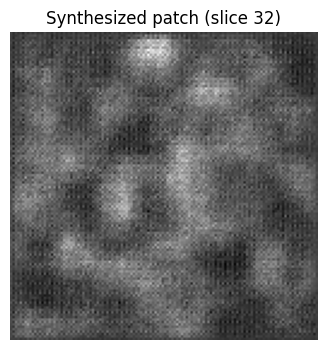

In [30]:
# ┌──────────────────────────────────────────────────────────────────────────┐
# │ CELL 2: VAE definition & training, then DDPM on latents                 │
# └──────────────────────────────────────────────────────────────────────────┘

import torch, torch.nn as nn, torch.nn.functional as F
from torch.optim import Adam
from torch.amp import GradScaler, autocast
from tqdm import tqdm
from generative.networks.nets import DiffusionModelUNet

device = device = torch.device("cuda")

# 1) Small 3D VAE
class Small3DVAE(nn.Module):
    def __init__(self, in_ch=1, latent_ch=32):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv3d(in_ch, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv3d(32, 64, 4, 2, 1),   nn.ReLU(),
            nn.Conv3d(64, latent_ch, 4, 2, 1),
        )
        self.dec = nn.Sequential(
            nn.ConvTranspose3d(latent_ch, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose3d(64, 32, 4, 2, 1),         nn.ReLU(),
            nn.ConvTranspose3d(32, in_ch, 4, 2, 1),
            nn.Sigmoid(),
        )
    def encode(self, x): return self.enc(x)
    def decode(self, z): return self.dec(z)
    def forward(self, x):
        z     = self.encode(x)
        recon = self.decode(z)
        return recon, z

vae = Small3DVAE(in_ch=1, latent_ch=32).to(device)

# 2) Train VAE
vae_opt    = Adam(vae.parameters(), lr=1e-3)
vae_epochs = 5
scaler     = GradScaler()

for ep in range(vae_epochs):
    vae.train()
    total_loss = 0
    pbar = tqdm(train_loader, desc=f"VAE ep{ep}", ncols=70)
    for batch in pbar:
        x = batch["image"].to(device)
        vae_opt.zero_grad(set_to_none=True)
        with autocast(device_type="cuda"):
            recon, _ = vae(x)
            loss     = F.mse_loss(recon, x)
        scaler.scale(loss).backward()
        scaler.step(vae_opt)
        scaler.update()
        total_loss += loss.item()
        pbar.set_postfix({"loss": total_loss/(pbar.n or 1)})
    print(f"→ VAE epoch {ep} avg loss: {total_loss/len(train_loader):.4f}")

# freeze VAE
for p in vae.parameters(): p.requires_grad = False
vae.eval()

# 3) Build DDPM UNet on latent space
latent_ch   = 32
latent_size = (patch_size[0]//8, patch_size[1]//8, patch_size[2]//8)  # (8,16,16)

ddpm = DiffusionModelUNet(
    spatial_dims=3,
    in_channels=latent_ch,
    out_channels=latent_ch,
    num_channels=[32,64,128],
    attention_levels=[False,False,False],
    num_head_channels=[0,0,latent_ch],
    num_res_blocks=2,
).to(device)

from generative.inferers import DiffusionInferer

from generative.networks.schedulers import DDPMScheduler
from torch.optim import AdamW

scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="linear_beta")
inferer   = DiffusionInferer(scheduler=scheduler)
optimizer = AdamW(ddpm.parameters(), lr=1e-4, weight_decay=1e-5)

# 4) Train DDPM on latents
ddpm_opt = Adam(ddpm.parameters(), lr=2e-4)
n_epochs = 150
val_interval = 25

for epoch in range(n_epochs):
    ddpm.train()
    epoch_loss = 0
    pbar = tqdm(train_loader, desc=f"DDPM ep{epoch}", ncols=70)
    for batch in pbar:
        x = batch["image"].to(device)
        with torch.no_grad():
            z = vae.encode(x)           # B×32×8×16×16
        ddpm_opt.zero_grad(set_to_none=True)
        with autocast(device_type="cuda"):
            noise = torch.randn_like(z)
            t = torch.randint(0, scheduler.num_train_timesteps,
                              (z.shape[0],), device=device).long()
            pred = inferer(inputs=z, diffusion_model=ddpm,
                           noise=noise, timesteps=t)
            loss = F.mse_loss(pred, noise)
        scaler.scale(loss).backward()
        scaler.step(ddpm_opt)
        scaler.update()
        epoch_loss += loss.item()
        pbar.set_postfix({"loss": epoch_loss/(pbar.n or 1)})
    print(f"→ DDPM epoch {epoch} avg loss: {epoch_loss/len(train_loader):.4f}")

    # optional validation/sampling loop every val_interval...

# 5) Sample & decode
ddpm.eval()
z0 = torch.randn((1, latent_ch, *latent_size), device=device)
scheduler.set_timesteps(num_inference_steps=250)
with torch.no_grad(), autocast(device_type="cuda"):
    z_sample   = inferer.sample(
                    input_noise=z0,
                    diffusion_model=ddpm,
                    scheduler=scheduler
                 )
    patch_synth = vae.decode(z_sample).cpu()   # shape [1,1,Z,Y,X]

# visualize middle Z‐slice
import matplotlib.pyplot as plt
slice_idx = patch_size[0] // 2  # e.g. 64//2 = 32
plt.figure(figsize=(4,4))
plt.imshow(patch_synth[0, 0, slice_idx, :, :], cmap="gray")
plt.axis("off")
plt.title("Synthesized patch (slice {})".format(slice_idx))
plt.show()



### Visualization of the training images

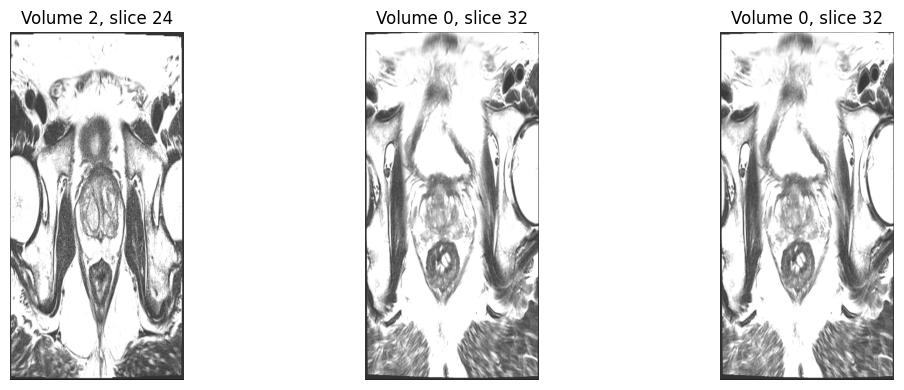

In [31]:
import random
import matplotlib.pyplot as plt
from monai.transforms import (
    Compose,
    Orientationd,
    Spacingd,
    ScaleIntensityRanged,
    DivisiblePadd,
    ToTensord,
)
from monai.data import PersistentDataset, DataLoader

# 1) Full‐volume transforms
full_transforms = Compose([
    LoadMHAwithSimpleITK(),                          # dict→dict
    Orientationd(keys=["image"], axcodes="RAS"),
    Spacingd(keys=["image"], pixdim=pixdim, mode="linear"),
    ScaleIntensityRanged(
        keys=["image"], a_min=-100, a_max=400,
        b_min=0.0,  b_max=1.0,  clip=True
    ),                                                # dict→dict
    DivisiblePadd(
        keys=["image"], k=8,
        mode="constant", constant_values=0
    ),                                                # dict→dict
    ToTensord(keys=["image"]),                       # dict→dict → tensor
])

# 2) Build & load
viz_dataset = PersistentDataset(
    data=data_dicts,        # same list of {"image": path}
    transform=full_transforms,
    cache_dir="./viz_cache"
)
viz_loader = DataLoader(viz_dataset, batch_size=1, shuffle=False)

# 3) Visualize three random mid‐slices
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax in axes:
    idx = random.randrange(len(viz_dataset))
    vol = viz_dataset[idx]["image"][0].cpu().numpy()  # [Z, Y, X]
    mid = vol.shape[0] // 2
    ax.imshow(vol[mid], cmap="gray", vmin=0, vmax=1)
    ax.set_title(f"Volume {idx}, slice {mid}")
    ax.axis("off")

plt.tight_layout()
plt.show()


### Define network, scheduler, optimizer, and inferer

We will use a DDPM in this example; for that, we need to define a `DiffusionModelUNet` network that will have as input the noisy images and the values for the timestep `t`, and it will predict the noise that is present in the image.

In this example, we have a network with three levels (with 256, 256, and 512 channels in each). In every level, we will have two residual blocks, and only the last one will have an attention block with a single attention head (with 512 channels).

In [33]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=3,
    in_channels=1, out_channels=1,
    num_channels=[32, 64, 128],      # 3 levels
    attention_levels=[False, False, False],
    num_head_channels=[0, 64, 128],
    num_res_blocks=2,
).to(device)

# keep DivisiblePad(k=16)
DivisiblePadd(keys=["image"], k=16, mode="constant", constant_values=0)

Together with our U-net, we need to define the Noise Scheduler for the diffusion model. This scheduler is responsible for defining the amount of noise that should be added in each timestep `t` of the diffusion model's Markov chain. Besides that, it has the operations to perform the reverse process, which will remove the noise of the images (a.k.a. denoising process). In this case, we are using a `DDPMScheduler`. Here we are using 1000 timesteps and a `scaled_linear` profile for the beta values (proposed in [Rombach et al. "High-Resolution Image Synthesis with Latent Diffusion Models"](https://arxiv.org/abs/2112.10752)). This profile had better results than the `linear, proposed in the original DDPM's paper. In `beta_start` and `beta_end`, we define the limits for the beta values. These are important to determine how accentuated is the addition of noise in the image.

In [34]:
scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="scaled_linear_beta", beta_start=0.0005, beta_end=0.0195)

Text(0, 0.5, 'alpha cumprod')

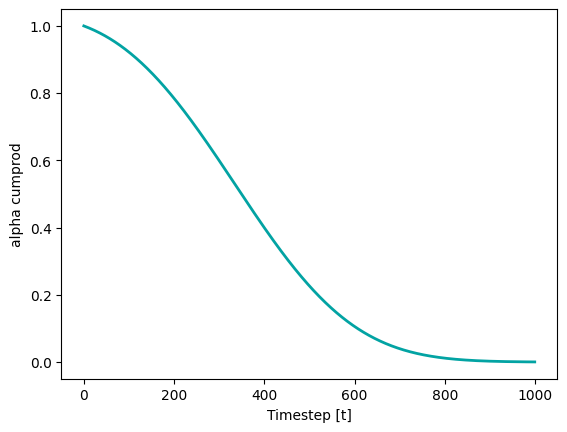

In [35]:
plt.plot(scheduler.alphas_cumprod.cpu(), color=(2 / 255, 163 / 255, 163 / 255), linewidth=2)
plt.xlabel("Timestep [t]")
plt.ylabel("alpha cumprod")

Finally, we define the Inferer, which contains functions that will help during the training and sampling of the model, and the optimizer.

In [36]:
inferer = DiffusionInferer(scheduler)

optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-5)

## Model training

In this part, we will train the diffusion model to predict the noise added to the images. For this, we are using an MSE loss between the prediction and the original noise. During the training, we are also sampling brain images to evaluate the evolution of the model. In this training, we use Automatic Mixed Precision to save memory and speed up the training.

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 91.89it/s]


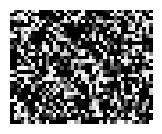

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 91.90it/s]


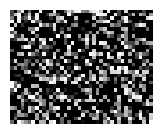

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.41it/s]


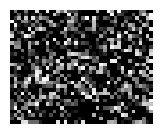

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 89.07it/s]


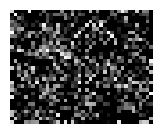

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 90.29it/s]


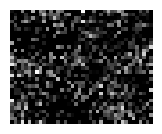

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 90.79it/s]


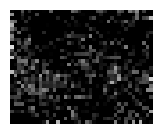

train completed, total time: 116.19596767425537.


In [37]:
n_epochs = 150
val_interval = 25
epoch_loss_list = []
val_epoch_loss_list = []

scaler = GradScaler()
total_start = time.time()
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer.zero_grad(set_to_none=True)

        with autocast(device_type="cuda"):
            # Generate random noise
            noise = torch.randn_like(images).to(device)

            # Create timesteps
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long()

            # Get model prediction
            noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)

            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_loss_list.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        for step, batch in enumerate(val_loader):
            images = batch["image"].to(device)
            noise = torch.randn_like(images).to(device)
            with torch.no_grad():
                with autocast(device_type="cuda"):
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                    ).long()

                    # Get model prediction
                    noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
                    val_loss = F.mse_loss(noise_pred.float(), noise.float())

            val_epoch_loss += val_loss.item()
            progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
        val_epoch_loss_list.append(val_epoch_loss / (step + 1))

        # Sampling image during training
        image = torch.randn((1, 1, 32, 40, 32))
        image = image.to(device)
        scheduler.set_timesteps(num_inference_steps=1000)
        with autocast(device_type="cuda"):
            image = inferer.sample(input_noise=image, diffusion_model=model, scheduler=scheduler)

        plt.figure(figsize=(2, 2))
        plt.imshow(image[0, 0, :, :, 15].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

### Learning curves

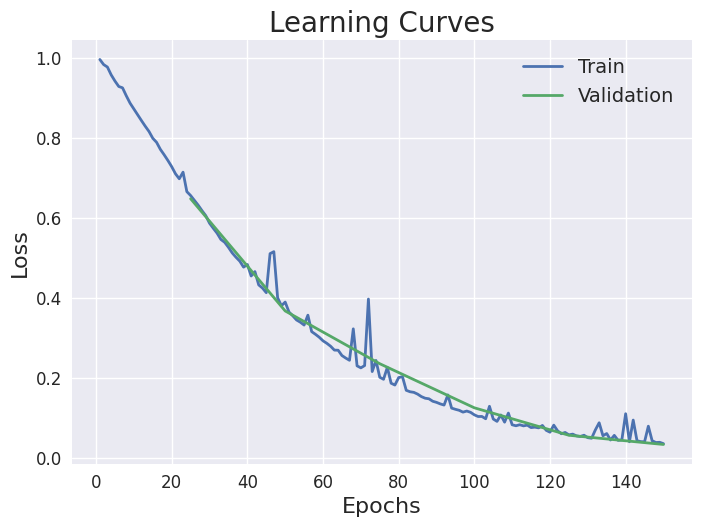

In [38]:
plt.style.use("seaborn-v0_8")
plt.title("Learning Curves", fontsize=20)
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_loss_list, color="C0", linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)),
    val_epoch_loss_list,
    color="C1",
    linewidth=2.0,
    label="Validation",
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

## Sampling Brain Image

In order to sample the brain images, we need to pass the model an image containing just noise and use it to remove the noise of the image iteratively. For that, we will use the `.sample()` function of the `inferer`.

100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [00:03<00:00, 83.19it/s]


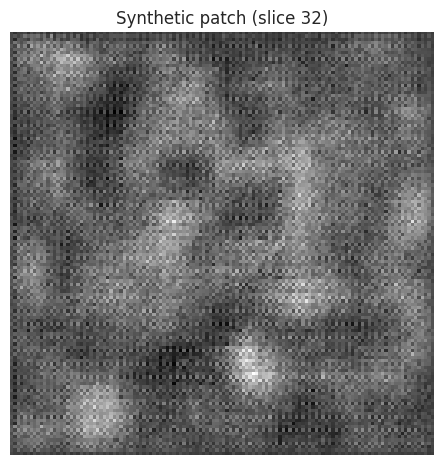

In [42]:
ddpm.eval()
vae.eval()

# 1. white-noise latent (batch=1)
latent_noise = torch.randn((1, 32, 8, 16, 16), device=device)

# 2. inference steps
scheduler.set_timesteps(num_inference_steps=250)  # 250–1000 works; fewer = faster

with torch.no_grad(), autocast(device_type="cuda"):
    # 3. denoise in latent space
    latent_denoised = inferer.sample(
        input_noise      = latent_noise,
        diffusion_model  = ddpm,
        scheduler        = scheduler
    )

    # 4. decode to image patch
    patch = vae.decode(latent_denoised)           # shape [1, 1, 64, 128, 128]

# 5. visualise a central axial slice
import matplotlib.pyplot as plt
mid_z = patch.shape[2] // 2
plt.imshow(patch[0, 0, mid_z].cpu(), cmap="gray")
plt.axis("off")
plt.title(f"Synthetic patch (slice {mid_z})")
plt.show()


### Sampling with Denoising Diffusion Implicit Model Scheduler

Recent papers have proposed different ways to improve the sampling speed by using fewer steps in the denoising process. In this example, we are using a `DDIMScheduler` (from [Song et al. "Denoising Diffusion Implicit Models"](https://arxiv.org/abs/2010.02502)) to reduce the original number of steps from 1000 to 250.

100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [00:02<00:00, 98.73it/s]


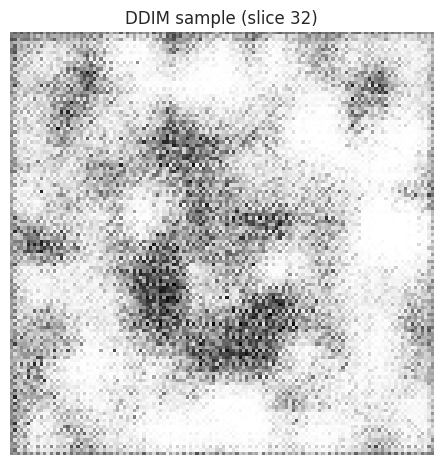

In [41]:
from generative.networks.schedulers import DDIMScheduler

# 1.  create a DDIM scheduler
scheduler_ddim = DDIMScheduler(
    num_train_timesteps = 1000,
    schedule            = "scaled_linear_beta",   # one of the valid names
    beta_start          = 0.0005,
    beta_end            = 0.0195,
    clip_sample         = False,                  # keep latent in original range
)

# 2.  choose how many denoising steps you want to **run**
#     (≤ num_train_timesteps). 250‒400 is a common choice.
scheduler_ddim.set_timesteps(num_inference_steps = 250)

# 3.  sample in LATENT space with the *ddpm* UNet
ddpm.eval()
vae.eval()

latent_noise = torch.randn((1, 32, 8, 16, 16), device=device)  # latents, not images

with torch.no_grad(), autocast(device_type="cuda"):
    latent_denoised = inferer.sample(
        input_noise     = latent_noise,
        diffusion_model = ddpm,            # <- your latent-UNet
        scheduler       = scheduler_ddim,
    )
    patch = vae.decode(latent_denoised)    # back to image space  [1,1,64,128,128]

# 4.  show a slice
import matplotlib.pyplot as plt
mid_z = patch.shape[2] // 2
plt.imshow(patch[0, 0, mid_z].cpu(), cmap="gray")
plt.axis("off")
plt.title(f"DDIM sample (slice {mid_z})")
plt.show()